In [53]:
from pathlib import Path 
from datetime import datetime
import pandas as pd
import numpy as np
from glob import glob

In [42]:
path_data = Path(f"./Challenge 3 Variation mesures sondes fixes")
network_state_path = path_data / f"Etats reseaux telecoms"

measure_df = pd.read_csv(path_data / f"Mesures_exposition_sondes_autonomes.csv", sep=";")
mse_df = pd.read_csv(path_data / f"Dates_mise-en-service_sondes_autonomes.csv", sep=",")

In [55]:
measure_df["date"]

0         27/02/2020 01:06
1         27/02/2020 01:06
2         27/02/2020 01:06
3         27/02/2020 03:06
4         27/02/2020 03:06
                ...       
419956    05/10/2022 23:06
419957    05/10/2022 23:06
419958    05/10/2022 23:06
419959    05/10/2022 23:06
419960    05/10/2022 23:06
Name: date, Length: 419961, dtype: object

# Enrichissement de `measure_df`

In [78]:
measure_df["datetime"] = [datetime.strptime(d, "%d/%m/%Y %H:%M") for d in measure_df["date"]]
measure_df["weekday"] = [f.weekday() for f in measure_df["datetime"]]
measure_df["month"] = [f.month for f in measure_df["datetime"]]
measure_df["day"] = [f.day for f in measure_df["datetime"]]
measure_df["hour"] = [f.hour for f in measure_df["datetime"]]

In [79]:
measure_df

,E_volt_par_metre,date,ville,code_postal,adresse,numero,latitude,longitude,datetime,weekday,month,day,hour
0,0.93,27/02/2020 01:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.304390,5.367127,2020-02-27 01:06:00,3,2,27,1
1,0.84,27/02/2020 01:06,Marseille,13006,Cours Pierre Puget,Marseille_02,43.290324,5.374826,2020-02-27 01:06:00,3,2,27,1
2,1.33,27/02/2020 01:06,Marseille,13007,31 Chemin de la Batterie des Lions,Marseille_03,43.281023,5.350082,2020-02-27 01:06:00,3,2,27,1
3,0.81,27/02/2020 03:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.304390,5.367127,2020-02-27 03:06:00,3,2,27,3
4,0.62,27/02/2020 03:06,Marseille,13006,Cours Pierre Puget,Marseille_02,43.290324,5.374826,2020-02-27 03:06:00,3,2,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419956,1.62,05/10/2022 23:06,Le_Taillan-Médoc,33200,86 Avenue du Stade,Le Taillan-Médoc_01,44.916404,-0.683546,2022-10-05 23:06:00,2,10,5,23
419957,0.26,05/10/2022 23:06,Paris,75008,84 Boulevard Haussmann,Paris_8e_03,48.874211,2.324807,2022-10-05 23:06:00,2,10,5,23
419958,0.98,05/10/2022 23:06,Mulhouse,68200,3 Rue Henri Dunant,Mulhouse_02,47.770411,7.320358,2022-10-05 23:06:00,2,10,5,23
419959,0.75,05/10/2022 23:06,Strasbourg,67000,Rue du 22 Novembre,Strasbourg_01,48.582774,7.745277,2022-10-05 23:06:00,2,10,5,23


In [29]:
network_state_dict = {}
for path in network_state_path.glob("*.csv"):
    date = path.name.split("_Etat reseaux.csv")[0]
    network_state_dict[date] = pd.read_csv(path.absolute(), sep=";")

In [32]:
print(f"les dates disponibles : {tuple(network_state_dict.keys())}")

les dates disponibles : ('2020_03_31', '2020_06_30', '2020_09_30', '2020_12_31', '2021_03_31', '2021_06_30', '2021_09_30', '2021_12_31', '2022_03_31', '2022_06_30', '2022_09_30')


In [30]:
network_state_dict["2020_03_31"]

,EMETTEUR ID,DATE MES EMETTEUR,SYSTEME TELECOM,GENERATION TELECOM,ANTENNE ID,AZIMUT ANTENNE,ALTITUDE ANTENNE,NUM STATION ANFR,OPERATEUR,ID SUPPORT,...,COR_NB_MN_LAT,COR_NB_SC_LAT,COR_CD_NS_LAT,COR_NB_DG_LON,COR_NB_MN_LON,COR_NB_SC_LON,COR_CD_EW_LON,LATITUDE DD,LONGITUDE DD,NUMERO SONDE FIXE
0,2311395,15/05/1994,GSM 900,2G,239926,150.0,"32,8",132290036,ORANGE,759406,...,17,33,N,5,22,36,E,43.292500,5.376667,Marseille_02
1,2311401,15/05/1994,GSM 900,2G,239928,30.0,"32,8",132290036,ORANGE,759406,...,17,33,N,5,22,36,E,43.292500,5.376667,Marseille_02
2,2311407,15/05/1994,GSM 900,2G,239930,270.0,"32,8",132290036,ORANGE,759406,...,17,33,N,5,22,36,E,43.292500,5.376667,Marseille_02
3,2973898,23/06/1995,GSM 900,2G,2617665,0.0,31,132700319,SFR,449181,...,17,26,N,5,22,26,E,43.290556,5.373889,Marseille_02
4,2973908,23/06/1995,GSM 900,2G,2617667,240.0,31,132700319,SFR,449181,...,17,26,N,5,22,26,E,43.290556,5.373889,Marseille_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,11995457,15/01/2020,UMTS 2100,3G,5713308,260.0,"27,6",442750630,BOUYGUES TELECOM,2136870,...,12,23,N,1,34,27,W,47.206389,-1.574167,Nantes_02
701,11995475,15/01/2020,UMTS 2100,3G,5713310,80.0,"27,6",442750630,BOUYGUES TELECOM,2136870,...,12,23,N,1,34,27,W,47.206389,-1.574167,Nantes_02
702,11995447,15/01/2020,UMTS 900,3G,5713306,350.0,"27,6",442750630,BOUYGUES TELECOM,2136870,...,12,23,N,1,34,27,W,47.206389,-1.574167,Nantes_02
703,11995461,15/01/2020,UMTS 900,3G,5713308,260.0,"27,6",442750630,BOUYGUES TELECOM,2136870,...,12,23,N,1,34,27,W,47.206389,-1.574167,Nantes_02


# Afficher une sonde

In [39]:
sonde = f"Marseille_{1:0>2}"

In [41]:
measure_df

,E_volt_par_metre,date,ville,code_postal,adresse,numero,latitude,longitude
0,0.93,27/02/2020 01:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.304390,5.367127
1,0.84,27/02/2020 01:06,Marseille,13006,Cours Pierre Puget,Marseille_02,43.290324,5.374826
2,1.33,27/02/2020 01:06,Marseille,13007,31 Chemin de la Batterie des Lions,Marseille_03,43.281023,5.350082
3,0.81,27/02/2020 03:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.304390,5.367127
4,0.62,27/02/2020 03:06,Marseille,13006,Cours Pierre Puget,Marseille_02,43.290324,5.374826
...,...,...,...,...,...,...,...,...
419956,1.62,05/10/2022 23:06,Le_Taillan-Médoc,33200,86 Avenue du Stade,Le Taillan-Médoc_01,44.916404,-0.683546
419957,0.26,05/10/2022 23:06,Paris,75008,84 Boulevard Haussmann,Paris_8e_03,48.874211,2.324807
419958,0.98,05/10/2022 23:06,Mulhouse,68200,3 Rue Henri Dunant,Mulhouse_02,47.770411,7.320358
419959,0.75,05/10/2022 23:06,Strasbourg,67000,Rue du 22 Novembre,Strasbourg_01,48.582774,7.745277


In [60]:
measure_df[measure_df["numero"]==sonde]

,E_volt_par_metre,date,ville,code_postal,adresse,numero,latitude,longitude,datetime
0,0.93,27/02/2020 01:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-02-27 01:06:00
3,0.81,27/02/2020 03:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-02-27 03:06:00
6,0.90,27/02/2020 07:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-02-27 07:06:00
9,1.16,27/02/2020 09:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-02-27 09:06:00
12,1.34,27/02/2020 11:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-02-27 11:06:00
...,...,...,...,...,...,...,...,...,...
419617,1.17,05/10/2022 15:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 15:06:00
419690,1.18,05/10/2022 17:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 17:06:00
419763,1.12,05/10/2022 19:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 19:06:00
419836,1.11,05/10/2022 21:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 21:06:00


In [51]:
timestamps = measure_df["date"]
print(len(timestamps))
print(len(set(timestamps)))
print(len(timestamps))


419961
21700


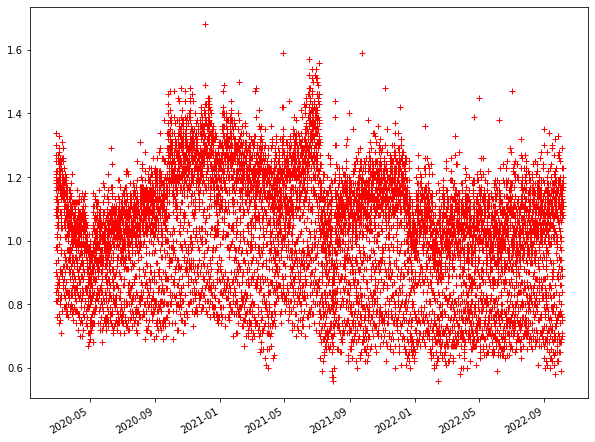

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
DF = pd.DataFrame()
DF['value'] = measure_df[measure_df["numero"]==sonde]["E_volt_par_metre"]
DF = DF.set_index(measure_df[measure_df["numero"]==sonde]["datetime"])
plt.plot(DF, 'r+')
plt.gcf().autofmt_xdate()
plt.show()

In [68]:
dt = measure_df[measure_df["numero"]==sonde]["datetime"][0]
dt.weekday()

3

In [94]:
measure_df["weekday"]==2

0         False
1         False
2         False
3         False
4         False
          ...  
419956     True
419957     True
419958     True
419959     True
419960     True
Name: weekday, Length: 419961, dtype: bool

In [103]:
((measure_df["numero"]==sonde) & (measure_df["weekday"]==2)).sum()

1563

In [105]:
measure_df[(measure_df["numero"]==sonde) & measure_df["weekday"]==2]

,E_volt_par_metre,date,ville,code_postal,adresse,numero,latitude,longitude,datetime,weekday,month,day,hour


In [69]:
xrange = tuple(range(7))
res = []
for x in xrange:
    res.append()


AttributeError: 'Series' object has no attribute 'weekday'

In [75]:
# network_state_df = 

In [108]:
dfs = []
for date, df in network_state_dict.items():
    df["date"] = date
    dfs.append(df)
network_state_df = pd.concat(dfs)
network_state_df.head()

705
711
707
3182
4098
5478
7013
7392
8444
9520
9447
56697 56697
